This notebook is to see how the model handles V1 and V2 metamers

In [2]:
import numpy                 as     np
import numpy.linalg          as     npl                 
import scipy                 as     sp
from   scipy                 import ndimage    as ndi
import pandas as pd
import seaborn as sns
import re
import shutil
import glob
import pickle

from   skimage               import data
from   skimage.util          import img_as_float
from   skimage.filters       import gabor_kernel
from   sklearn.preprocessing import scale

from   numbers               import Number   

import os, sys, math, itertools, collections

%matplotlib notebook
#%gui qt
import matplotlib
import matplotlib.pyplot     as     plt

import neuropythy            as     neuro
import neuropythy.freesurfer as     nfs

for p in ['/home/billbrod/Documents/SCO-test-data/Freesurfer_subjects', '/Volumes/server/Freesurfer_subjects/']:
    if p not in nfs.subject_paths():
        nfs.add_subject_path(p)

import sco
import freq_pref_check
import model_comparison_script
import pRF_check

def reload_sco():
    reload(sys.modules['sco.core'])
    reload(sys.modules['sco.anatomy.core'])
    reload(sys.modules['sco.stimulus.core'])
    reload(sys.modules['sco.pRF.core'])
    reload(sys.modules['sco.normalization.core'])
    reload(sys.modules['sco.anatomy'])
    reload(sys.modules['sco.stimulus'])
    reload(sys.modules['sco.pRF'])
    reload(sys.modules['sco.normalization'])
    reload(sys.modules['sco'])
    reload(sys.modules['sco.model_comparison'])
    reload(sys.modules['sco.model_comparison.core'])
    reload(sys.modules['sco.model_comparison.compare_with_Kay2013'])
    import sco

In [7]:
images = glob.glob(os.path.expanduser('~/sco/Metamer_images/Metamers/*png'))
results = sco.calc_sco(subject='test-sub', stimulus_image_filenames=images, max_eccentricity=7.5)

In [8]:
images = [os.path.split(i)[1] for i in images]
model_df = sco.model_comparison.create_model_dataframe(results, images, 'Metamer_images/model_df.csv')
plot_df = sco.model_comparison.core._create_plot_df(model_df)

In [9]:
def search_for_mets(x):
    tmp = re.search(r'(V[12]Met).*', x)
    if tmp is None:
        return "original"
    else:
        return tmp.groups()[0].replace('Met', '-metamer')

def search_for_noise_seed(x):
    tmp = re.search(r'D[0-9]+-([0-9]+).*png', x)
    if tmp is None:
        return None
    else:
        return tmp.groups()[0]

plot_df = plot_df[plot_df.language=='python']
plot_df['image_type'] = plot_df['image'].apply(search_for_mets)
plot_df['image_name'] = plot_df['image'].apply(lambda x: re.search(r'(D[0-9]+).*png', x).groups()[0])
plot_df['image_seed'] = plot_df['image'].apply(search_for_noise_seed)

In [203]:
results['pRF_frequency_preferences'][0]

{4.242640687119286: 1.0}

<IPython.core.display.Javascript object>


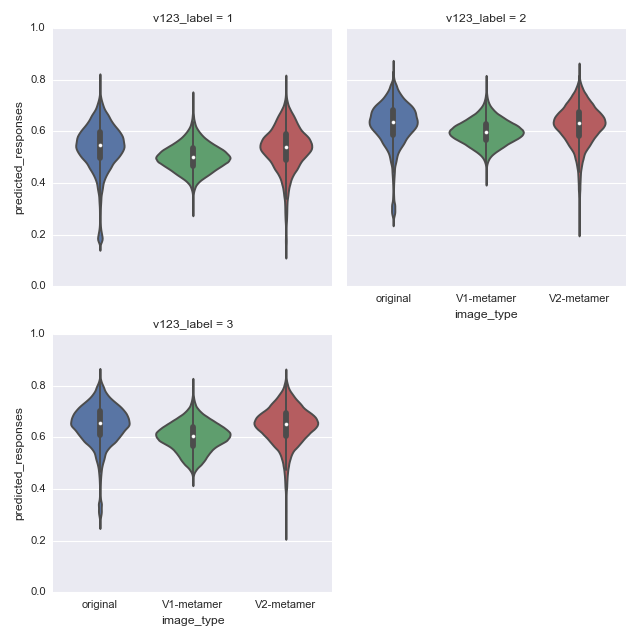

In [14]:
sns.factorplot(data=plot_df, y='predicted_responses', col='v123_label', x='image_type', 
               col_wrap=2, kind='violin')

In [127]:
original_df = plot_df[plot_df.image_type=='original']
original_df = original_df.set_index(['voxel', 'image_name'])

V1_df = plot_df[plot_df.image_type=='V1-metamer']
V1_df = V1_df.set_index(['voxel', 'image_name'])

V2_df = plot_df[plot_df.image_type=='V2-metamer']
V2_df = V2_df.set_index(['voxel', 'image_name'])

In [194]:
(V2_df.predicted_responses - V1_df.predicted_responses).loc[(0,'D1')]

/Users/winawerlab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


voxel  image_name
0      D1            0.010673
       D1            0.068926
       D1            0.055524
       D1           -0.089606
       D1           -0.031564
Name: predicted_responses, dtype: float64

In [148]:
summary_df = original_df[['v123_label']]
tmp_df = original_df[['predicted_responses']] - V1_df[['predicted_responses']]
summary_df['original - V1 SNR'] = tmp_df.reset_index().groupby(['voxel','image_name']).aggregate(lambda x: float(sp.stats.signaltonoise(x)))
summary_df['original - V1 mean'] = tmp_df.reset_index().groupby(['voxel','image_name']).aggregate(np.mean)

tmp_df = V2_df.predicted_responses - V1_df.predicted_responses
summary_df['V2 - V1 SNR'] = tmp_df.reset_index().groupby(['voxel','image_name']).aggregate(lambda x: float(sp.stats.signaltonoise(x)))
summary_df['V2 - V1 mean'] = tmp_df.reset_index().groupby(['voxel','image_name']).aggregate(np.mean)
 
tmp_df = original_df.predicted_responses - V2_df.predicted_responses
summary_df['original - V2 SNR'] = tmp_df.reset_index().groupby(['voxel','image_name']).aggregate(lambda x: float(sp.stats.signaltonoise(x)))
summary_df['original - V2 mean'] = tmp_df.reset_index().groupby(['voxel','image_name']).aggregate(np.mean)

summary_df = summary_df.reset_index()

tmp = pd.melt(summary_df, id_vars=['voxel', 'image_name', 'v123_label'], value_name='SNR',
              value_vars=['original - V1 SNR', 'V2 - V1 SNR', 'original - V2 SNR'])
tmp['variable'] = tmp.variable.apply(lambda x: x.replace(' SNR', ''))

tmp2 = pd.melt(summary_df, id_vars=['voxel', 'image_name', 'v123_label'], value_name='mean',
               value_vars=['original - V1 mean', 'V2 - V1 mean', 'original - V2 mean'])
tmp2['variable'] = tmp2.variable.apply(lambda x: x.replace(' mean', ''))

summary_df = pd.concat([tmp, tmp2], axis=1).T.groupby(level=0).first().T

# for some reason, these get cast as objects, and we want to make sure they're floats
summary_df['mean'] = summary_df['mean'].astype(np.float64)
summary_df['SNR'] = summary_df['SNR'].astype(np.float64)

/Users/winawerlab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/winawerlab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/winawerlab/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Because this SNR ratio varies so much, it's very hard to see the mean in the plot below. This shows that value, but the plot also allows us to see that the distributions don't vary much across visual areas

In [188]:
summary_df.head()

,SNR,image_name,mean,v123_label,variable,voxel
0,-9.301790,D1,-0.181069,2,original - V1,0
1,-4.301498,D1,-0.094246,3,original - V1,1
2,7.526969,D1,0.081981,3,original - V1,2
3,1.191425,D1,0.050783,3,original - V1,3
4,-4.514499,D1,-0.101406,3,original - V1,4


In [197]:
summary_df.groupby(['v123_label', 'variable'])[['SNR', 'mean']].mean()

SNR      mean
v123_label variable                         
1          V2 - V1        1.496391  0.033592
           original - V1  2.843155  0.043913
           original - V2  0.239896  0.010322
2          V2 - V1        1.260348  0.025562
           original - V1  2.255717  0.035081
           original - V2  0.227808  0.009519
3          V2 - V1        2.206549  0.042397
           original - V1  4.035209  0.050707
           original - V2  0.203421  0.008310

<IPython.core.display.Javascript object>


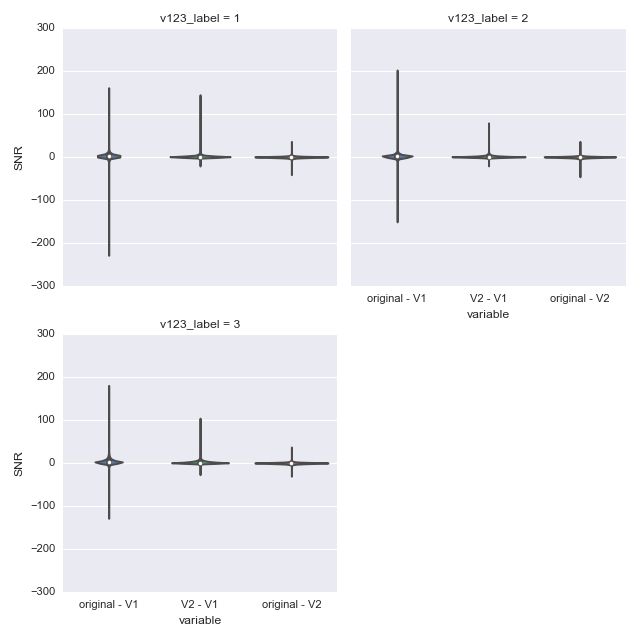

In [199]:
sns.factorplot(data=summary_df, y='SNR', x='variable', col='v123_label', kind='violin',
               col_wrap=2)

<IPython.core.display.Javascript object>


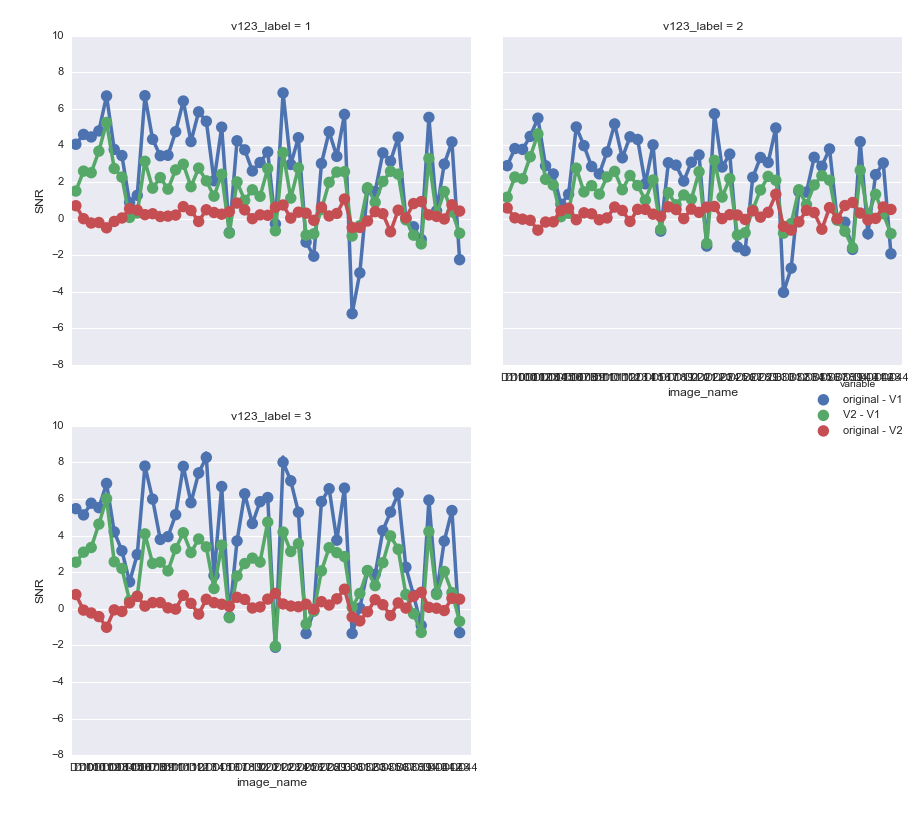

In [201]:
sns.factorplot(data=summary_df, y='SNR', x='image_name', col='v123_label', hue='variable',
               col_wrap=2,)

<IPython.core.display.Javascript object>


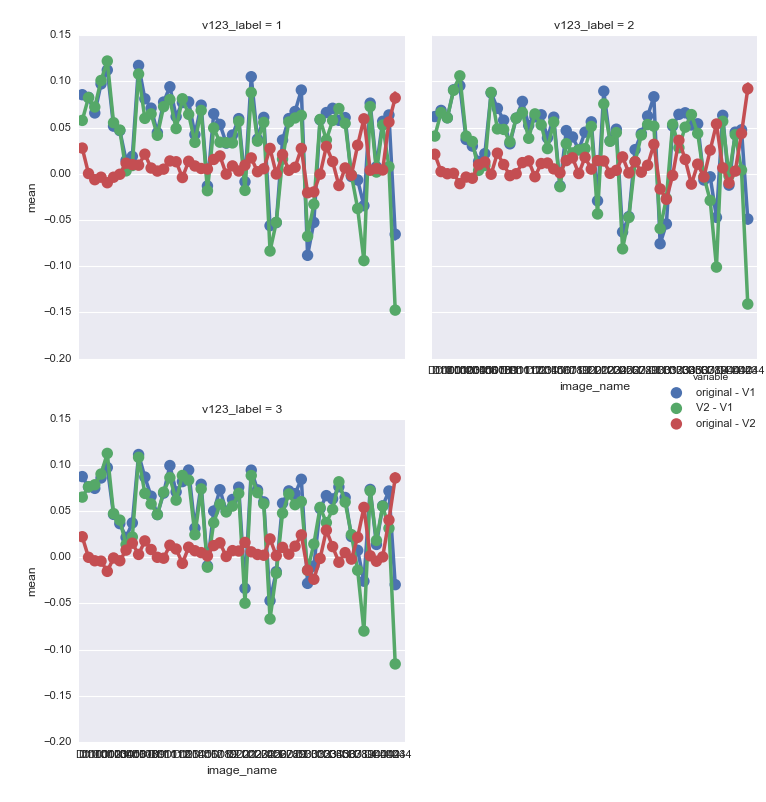

In [195]:
sns.factorplot(data=summary_df, y='mean', x='image_name', col='v123_label',
               col_wrap=2, hue='variable')